# Средняя зарплата

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [5]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/Users/aaboboshko/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


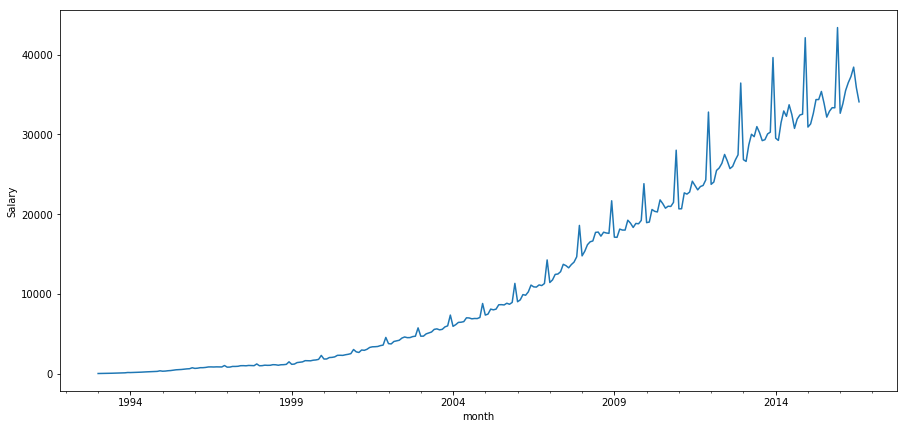

In [6]:
s = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], 
                parse_dates=['month'], dayfirst=True).rename(index=str, columns={"WAG_C_M":"salary"})
s = s.set_index(pd.to_datetime(s.index))
plt.figure(figsize(15,7))
s.salary.plot()
plt.ylabel('Salary')
pylab.show()

Видим якро выраженный тренд, сезонность и различие дисперсий.

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


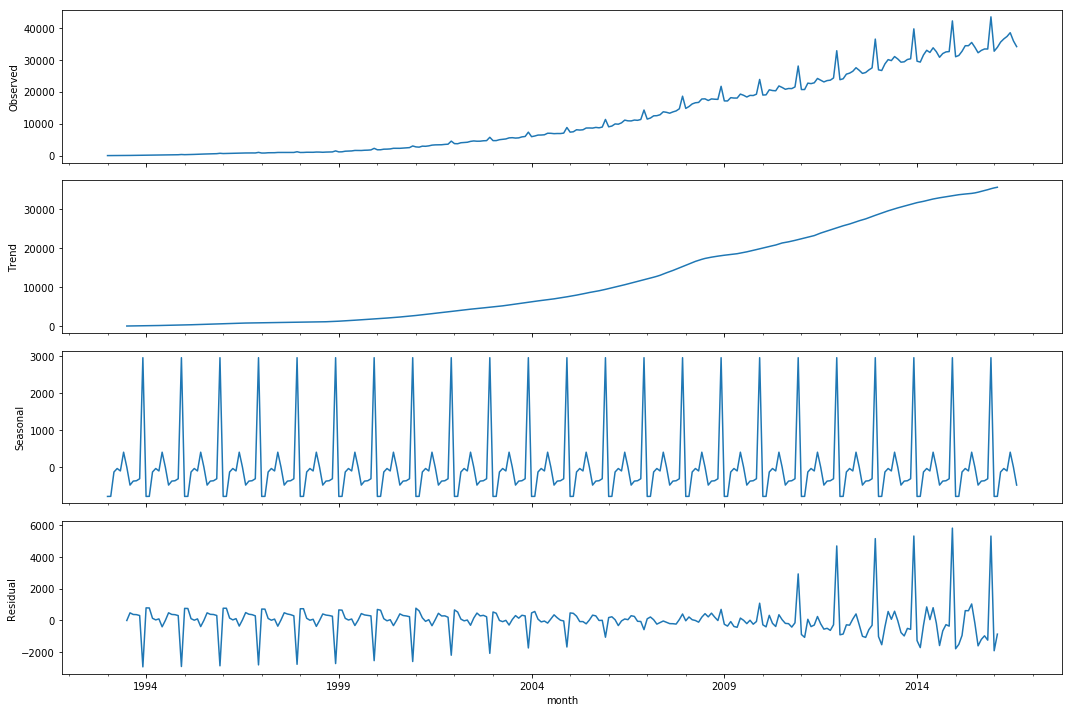

In [7]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(s.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary)[1])

Сам внешний вид ряда (тренд+сезонность) + pvalue теста говорит о том, что ряд оень вероятно нестационарен.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


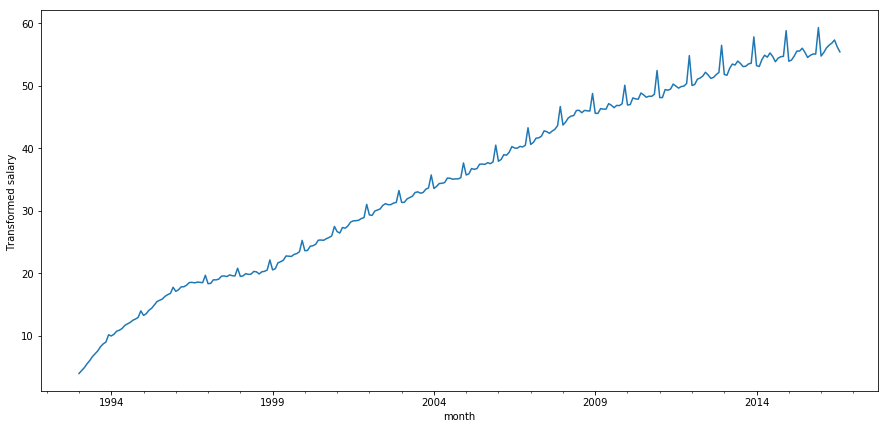

In [8]:
s['salary_box'], lmbda = stats.boxcox(s.salary)
plt.figure(figsize(15,7))
s.salary_box.plot()
plt.ylabel(u'Transformed salary ')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary_box)[1])

После преобразования все равно дисперсия не стабилизировалась + критерий не позволяет принять гипотезу о стационарности ряда с хорошим уровнем значимости.

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


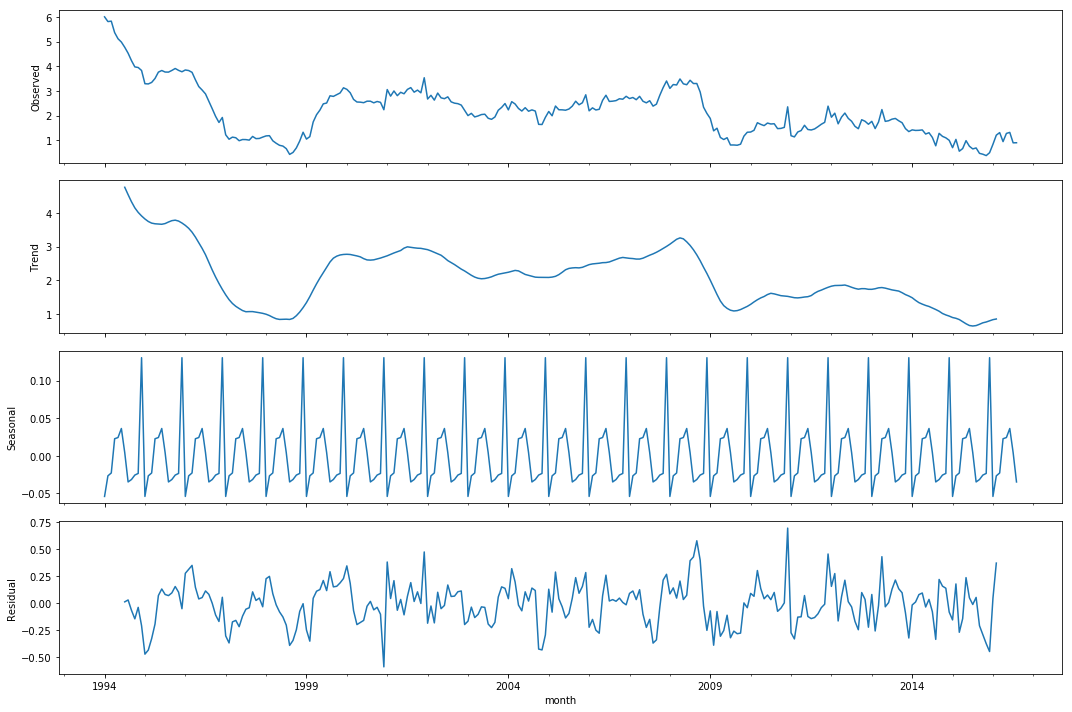

In [9]:
s['salary_box_diff'] = s.salary_box - s.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(s.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


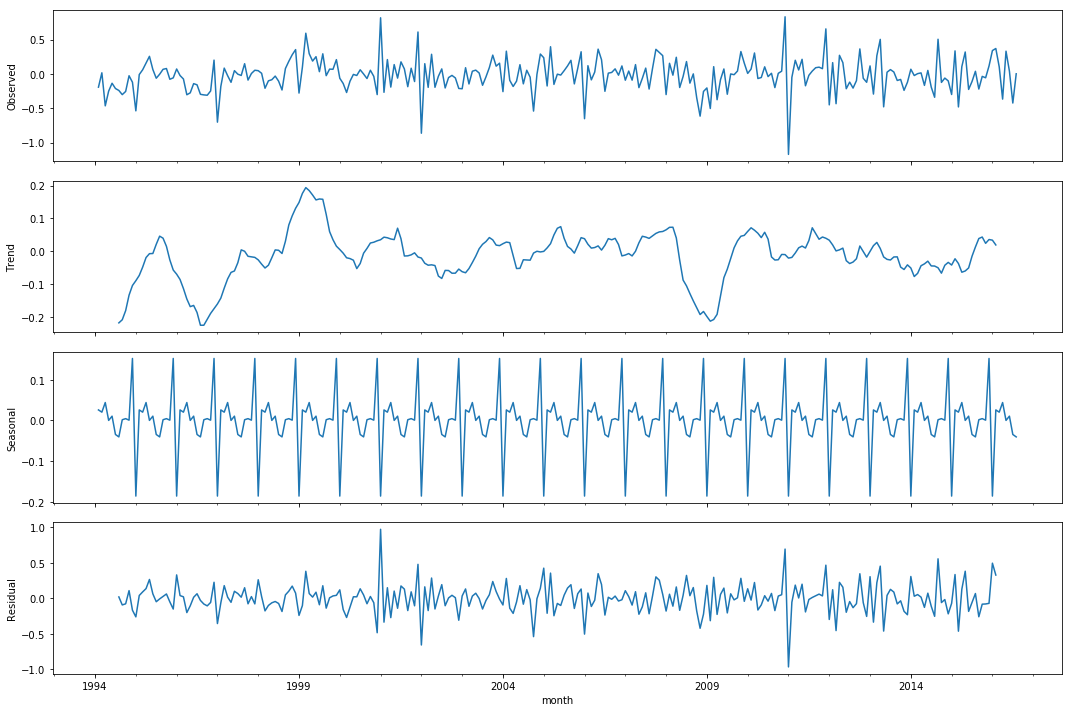

In [10]:
s['salary_box_diff2'] = s.salary_box_diff - s.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(s.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(s.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

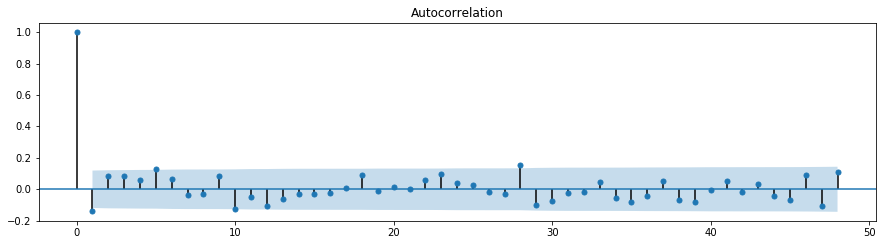

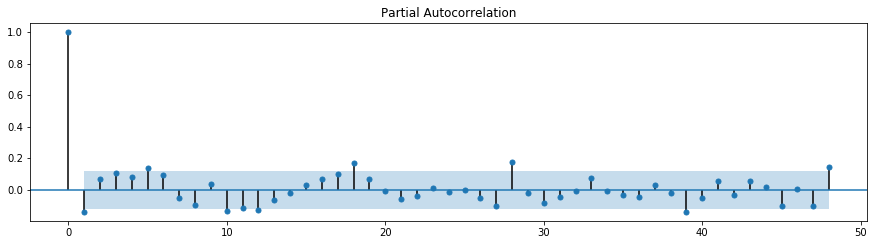

In [11]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(s.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(s.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Выбираем начальные приближения


По коррелограмме автокорреляций: 

Максимальный сезонный значимый лаг = 0 = 0*12 ; 0 = Q

Максимальный несезонный значимый лаг, меньший сезона (12) = 5 ; 5 = q


По коррелограмме частичных автокорреляций: 

Максимальный сезонный значимый лаг = 48 =  4*12 ; 4 = P

Максимальный несезонный значимый лаг, меньший сезона (12) = 10; 10 = p

Начальные приближения: Q=0, q=6, P=4, p=10

In [25]:
ps = range(0, 11)
d=1
qs = range(0, 6)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [26]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

330

In [18]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(s.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 2, 0))
('wrong parameters:', (1, 2, 3, 0))
('wrong parameters:', (1, 2, 4, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 2, 0))
('wrong parameters:', (2, 2, 3, 0))
('wrong parameters:', (2, 2, 4, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 2, 0))
('wrong parameters:', (3, 2, 3, 0))
('wrong parameters:', (3, 2, 4, 0))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 2, 0))
('wrong parameters:', (4, 2, 3, 0))
('wrong parameters:', (4, 2, 4, 0))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (4, 4,

In [19]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(144))

        parameters        aic
156   (5, 5, 1, 0) -25.158615
141   (4, 6, 1, 0) -25.106208
136   (4, 5, 1, 0) -25.024324
157   (5, 5, 2, 0) -23.592313
137   (4, 5, 2, 0) -22.732899
181   (6, 5, 1, 0) -22.592829
155   (5, 5, 0, 0) -22.293222
143   (4, 6, 3, 0) -22.019741
142   (4, 6, 2, 0) -21.830274
158   (5, 5, 3, 0) -21.634945
159   (5, 5, 4, 0) -21.502746
144   (4, 6, 4, 0) -21.247591
182   (6, 5, 2, 0) -21.177696
70    (2, 3, 0, 0) -21.091494
138   (4, 5, 3, 0) -20.408741
161   (5, 6, 1, 0) -20.399852
71    (2, 3, 1, 0) -20.398611
180   (6, 5, 0, 0) -20.054676
139   (4, 5, 4, 0) -19.655386
186   (6, 6, 1, 0) -19.543763
184   (6, 5, 4, 0) -19.529602
183   (6, 5, 3, 0) -19.447535
116   (3, 6, 1, 0) -19.426457
72    (2, 3, 2, 0) -19.419223
162   (5, 6, 2, 0) -19.283320
75    (2, 4, 0, 0) -19.141102
117   (3, 6, 2, 0) -19.013591
76    (2, 4, 1, 0) -18.959573
187   (6, 6, 2, 0) -18.893027
160   (5, 6, 0, 0) -18.847681
..             ...        ...
256  (10, 1, 1, 0)  -7.168053
167   (6, 

Лучшая модель:

In [20]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.579
Date:                            Fri, 15 Feb 2019   AIC                            -25.159
Time:                                    11:31:17   BIC                             18.067
Sample:                                01-01-1993   HQIC                            -7.803
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2180      0.731     -0.298      0.765      -1.650       1.214
ar.L2          0.2450      0.518   

Её остатки:

Критерий Стьюдента: p=0.166552
Критерий Дики-Фуллера: p=0.000000


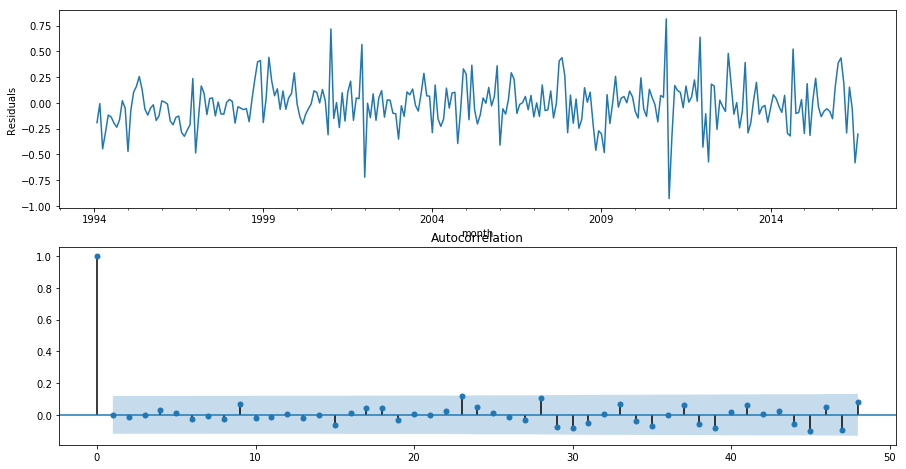

In [21]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

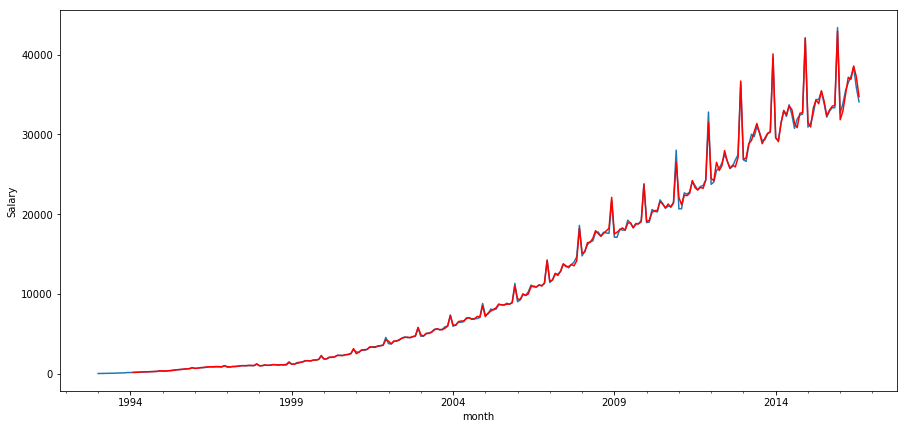

In [22]:
s['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
s.salary.plot()
s.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

Вроде хорошо:)

### Прогноз

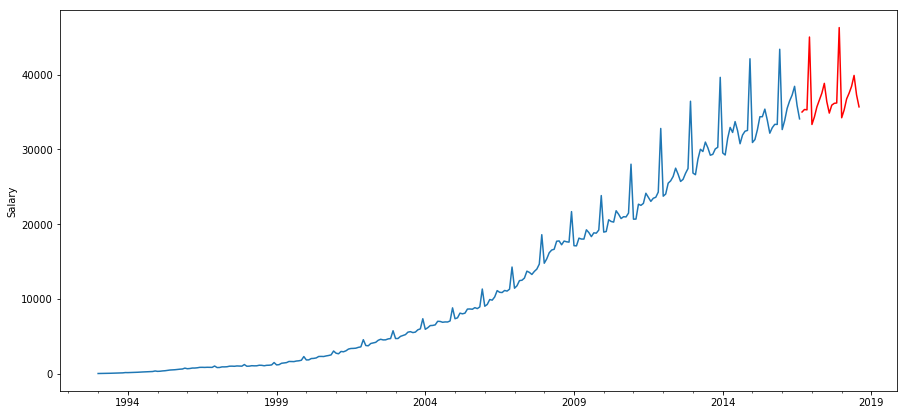

In [23]:
s2 = s[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= s2.columns)
s2 = pd.concat([s2, future])
s2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
s2.salary.plot()
s2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

Прогноз учел характер временного ряда, кажется вполне адекватным